## **Preparando o ambiente**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Instalando as bibliotecas necessárias

In [ ]:
!pip install rasterio
!pip install geopandas

In [ ]:
import rasterio
from rasterio.plot import show
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import pandas as pd
import seaborn as sns
import geopandas as gpd

Agora, vamos importar a imagem. Primeiro definimos o caminho do arquivo:

In [ ]:
path_img = '/content/drive/Shareddrives/Disciplinas UFSM UFVJM/Extração de  informações/1. Segmentação e classificação de imagens/Colab/DB UFVJM/cipef_50cm_v2.tif'

Vamos agora usar o Rasterio para abrir o arquivo e ler o source.

In [ ]:
src = rasterio.open(path_img)

In [ ]:
img = src.read()
img

In [ ]:
img.shape

Vimos que o shape do array que representa a imagem está na ordem C x H x W, onde C representa a quantidade de canais ou bandas, H a quantidade de linhas e W a quantidade de colunas. A maioria de pacotes do python representa uma imagem no formato H x W x C. Então vamos realizar essa transposição do eixo C para o final:

In [ ]:
img = img.transpose([1,2,0])
img.shape

Então selecionaremos os canais Red, Blue e Green para podermos plotar uma imagem RGB da área de estudo:

In [ ]:
red = img[:,:,0]
green = img[:,:,1]
blue = img[:,:,2]

Concatenamos os canais em um único array e plotamos com o matplotlib:

(-0.5, 268.5, 237.5, -0.5)

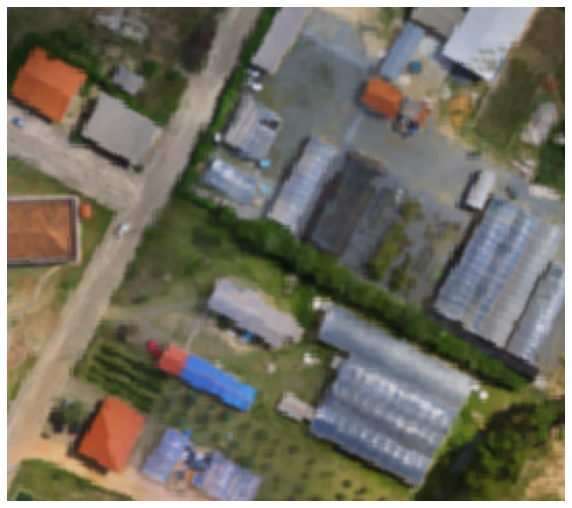

In [ ]:
rgb = np.dstack((red, green, blue))
plt.figure(figsize=[10,10])
plt.imshow(rgb*1)
plt.axis('off')

Agora é hora de importar com o geopandas os pontos coletados:

In [ ]:
pontos = gpd.read_file('/content/drive/Shareddrives/Disciplinas UFSM UFVJM/Extração de  informações/1. Segmentação e classificação de imagens/Colab/DB UFVJM/cipef_poi.shp') 

In [ ]:
pontos

Antes de realizar a amostragem na imagem com os pontos coletados, devemos verificar se os crs tem os mesmos valores:

In [ ]:
print(pontos.crs)

In [ ]:
print(src.crs)

In [ ]:
cmap = ListedColormap(['blue','red'])

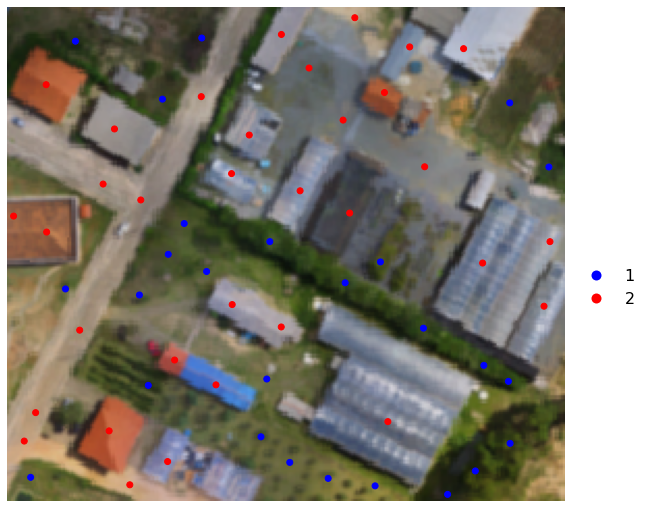

In [ ]:
cmap = ListedColormap(['blue','red'])
fig, ax = plt.subplots(figsize=(10,10))
pontos.plot(column='class', categorical=True, cmap=cmap, legend=True, legend_kwds={'bbox_to_anchor':(1, 0.5),'loc':'upper left','fontsize':16,'frameon':False}, ax=ax)
ax.axis('off')
show(rgb.transpose([2,0,1])*1, transform=src.transform, ax=ax)

Criaremos um for para cada ponto, selecionando o valor do pixel correspondente para cada banda espectral:

In [ ]:
pontos['geometry']

In [ ]:
array_pontos = []
for point in pontos['geometry']:
  x = point.xy[0][0]
  y = point.xy[1][0]
  row, col = src.index(x,y)
  band_value = []
  for i in range(src.count):
    band_value.append(src.read(i+1)[row,col])
  array_pontos.append(band_value)

No final convertermos a lista para um array:

In [ ]:
X = np.array(array_pontos)

Esse array terá a quantidade de pontos X numero de bandas:

In [ ]:
X.shape

(59, 4)

Chamaremos de Y os valores alvos definidos na coleta pelo usuário:

In [ ]:
pontos['class']

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
26    2
27    2
28    2
29    2
30    2
31    2
32    2
33    2
34    2
35    2
36    2
37    2
38    2
39    2
40    2
41    2
42    2
43    2
44    2
45    2
46    2
47    2
48    2
49    2
50    2
51    2
52    2
53    2
54    2
55    2
56    2
57    2
58    2
Name: class, dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
Y = pontos['class'].values
labelencoder = LabelEncoder()
Y = labelencoder.fit_transform(Y)
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# Vamos agora realizar a classificação e verificar suas métricas

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler 
from sklearn.svm import SVC
from sklearn import svm

Primeiro separaremos os dados em dados de treinamento e dados de teste:

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [ ]:
clf_SVM = svm.SVC(C=1000.0, class_weight='balanced', gamma=0.005)

In [ ]:
clf_SVM.fit(X_train,Y_train)

SVC(C=1000.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.005,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [ ]:
print("Accuracy on training set: {:.2f}".format(clf_SVM.score(X_train, Y_train)))
print("Accuracy on test set: {:.2f}".format(clf_SVM.score(X_test, Y_test)))

Accuracy on training set: 1.00
Accuracy on test set: 0.89


Também podemos vereificar outras métricas de validação. Antes vamos predizer os dados de teste:

In [ ]:
y_pred=clf_SVM.predict(X_test)

In [ ]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.80      1.00      0.89         8

    accuracy                           0.89        18
   macro avg       0.90      0.90      0.89        18
weighted avg       0.91      0.89      0.89        18



In [ ]:
c_matrix = confusion_matrix(Y_test, y_pred)

In [ ]:
names = ['Vegetação','Construção']

Text(0.5, 51.0, 'Predict')

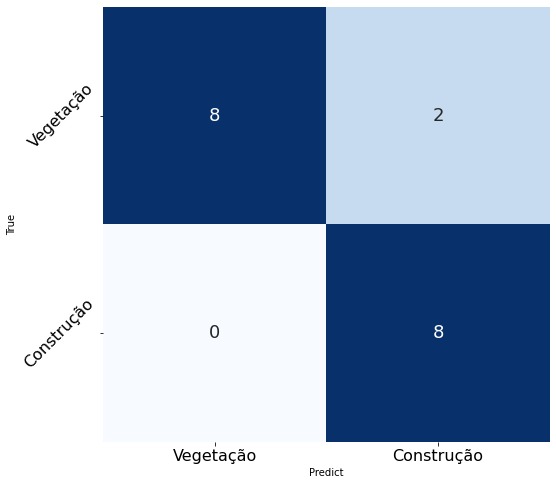

In [ ]:
r1 = pd.DataFrame(data=c_matrix, index= names, columns=names) 
fig, ax = plt.subplots(figsize=(8,8)) 
ax = sns.heatmap(r1, annot=True, annot_kws={"size": 18},fmt='d',cmap="Blues", cbar = False)
#for t in ax.texts: t.set_text(t.get_text() + " %")
ax.tick_params(labelsize=16)
ax.set_yticklabels(names, rotation=45)
ax.set_ylabel('True')
ax.set_xlabel('Predict')

# Após a verificação das métricas, vamos predizer todos os pixels da imagem, resultando no mapa final de uso e cobertura:

In [ ]:
Predict_img = np.nan_to_num(img)
Predict_img.shape

(238, 269, 4)

In [ ]:
Predict_img = Predict_img.reshape(img.shape[0]*img.shape[1],img.shape[2])

In [ ]:
array_pred=clf_SVM.predict(Predict_img)

In [ ]:
array_pred = array_pred.reshape(img.shape[0],img.shape[1])

(-0.5, 268.5, 237.5, -0.5)

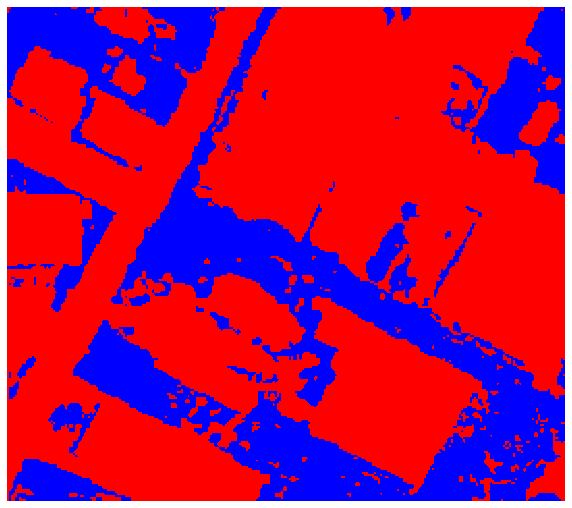

In [ ]:
plt.figure(figsize=[10,10])
plt.imshow(array_pred,cmap=cmap)
plt.axis('off')

# Estatísticas em Python

Vamos agora calcular as áres ocupads por cada classe. 
Primeiro podemos notar que cada pixels é representado por um valor de classe e uma posição de linha e de coluna no array de predições.

In [ ]:
array_pred

array([[1, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 1, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 1, 1],
       [1, 0, 1, ..., 0, 1, 1]])

Usando a função np.unique, vamos obter os valores únicos de classes e a quantidade por valor único que existe neste array.

In [ ]:
classes,quantidade =  np.unique(array_pred,return_counts=True)
quantidade

array([20505, 43517])

A partir da quantidade de pixels, vamos calcular a área de cada classe basicamente, multiplicando por 20x20 (Tamanho do pixel médio da Imagem do drone utilizada) e por 10000 (conversão de cm² para m²).

In [ ]:
areas = quantidade*20*20/10000

Adicionamos o nome das classes:

In [ ]:
nomes = ['Vegetação','Construção']

E empilhamos em um array:

In [ ]:
dados_stack = np.stack((classes,quantidade,areas,nomes))
dados_stack

array([['0', '1'],
       ['20505', '43517'],
       ['820.2', '1740.68'],
       ['Vegetação', 'Construção']], dtype='<U32')

Notem que as linhas representam cada informação. Entretanto, queremos que cada tipo de informação seja uma coluna para podermos plotar com alguma biblioteca (ex.: matplotlib ou o seaborn).
Então usamos a transposição de eixos, transformando linhas em colunas e vice-versa.

In [ ]:
dados_stack.T

array([['0', '20505', '820.2', 'Vegetação'],
       ['1', '43517', '1740.68', 'Construção']], dtype='<U32')

Assim conseguiremos converter em um dataframe, além de converter os valores de área para ponto flutuante.

In [ ]:
df_dados = pd.DataFrame(data=dados_stack.T, columns=['Codigos', 'Qtd','Área m²', 'Classes'])
df_dados['Área m²'] = df_dados['Área m²'].astype(np.float)
df_dados

,Codigos,Qtd,Área m²,Classes
0,0,20505,820.20,Vegetação
1,1,43517,1740.68,Construção


Agora, podemos plotar um gráfico de barras com as áreas por classe:

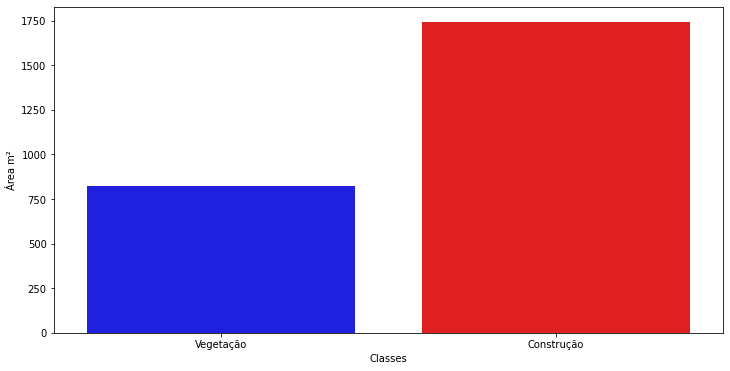

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,6))
ax1 = sns.barplot(x= 'Classes',y="Área m²", data=df_dados, palette=cmap.colors)

Outra maneira de representar essas informações é usando a porcentagem de área para cada classe:

In [ ]:
percent = quantidade*100/quantidade.sum()
percent

array([32.02805286, 67.97194714])

Podemos usar um Gráfico de Pizza para repesentar as porcentagens:

In [ ]:
wp = { 'linewidth' : 0.2, 'edgecolor' : "black" } 
explode = (0.0, 0.0) 

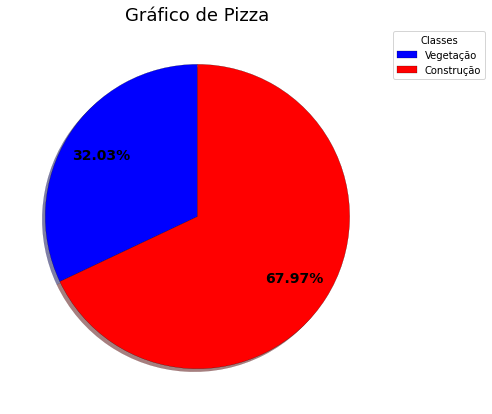

In [ ]:
fig, ax = plt.subplots(figsize =(10, 7)) 
wedges, texts, autotexts = ax.pie(percent,  
                                  autopct = '%1.2f%%',    
                                  shadow = True,
                                  explode = explode,  
                                  colors = cmap.colors, 
                                  pctdistance  = 0.75, 
                                  startangle = 90,
                                  wedgeprops = wp) 
  
# Adding legend 
ax.legend(wedges, nomes, 
          title ="Classes", 
          loc ="upper left", 
          bbox_to_anchor =(1, 0, 0.5, 1)) 
  
plt.setp(autotexts, size = 14, weight = 'bold') 
ax.set_title("Gráfico de Pizza",fontsize=18) 
  
# show plot 
plt.show() 

#Exportar nossa imagem classificada

In [ ]:
export_image = array_pred[np.newaxis,:,:]
array_pred.shape
export_image.shape

(1, 238, 269)

In [ ]:
out_meta = src.meta
out_meta

{'count': 4,
 'crs': CRS.from_epsg(31983),
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 238,
 'nodata': None,
 'transform': Affine(0.500071139240496, 0.0, 650876.4426878481,
       0.0, -0.5002079812215178, 7986919.5969981225),
 'width': 269}

In [ ]:
out_meta.update({"driver": "GTiff",
                  "height": export_image.shape[1],
                  "width": export_image.shape[2],
                  "compress":'lzw',
                  "count":1
                  })

In [ ]:
 with rasterio.open('/content/drive/MyDrive/Turma-PPGF804/Lulc_SVM.tif', "w", **out_meta) as dest:
     dest.write(export_image)